In [1]:
harmonic_dict = {'Wasserstein (LmmNet)': [0.00640513874452418,0.013165095903423425,0.022717725954431514,0.0163601126786862,0.010857359722811523,0.008366316357677024,0.007680638799629654,0.02912590463061618,0.008511330601081215,0.009477385272766238],
                 'Wasserstein (1step)': [0.03217873171638353,0.001175583644040351,0.04008663052803717,0.04794740870125156,0.058899735906104256,0.05808637088268815,0.06176615609870114,0.009088373404647276,0.011227078473448289,0.02779068583519824],
                 'DTW (LmmNet)': [0.0059301072774885725, 0.016246548964522274, 0.024871270805852837, 0.004082906779761292, 0.007730348635131506, 0.004109668070468808, 0.02350208282275281, 0.007950299509672803, 0.009735945182382733, 0.010943781331910419],
                 'DTW (1step)': [0.14192463645235445, 0.011225505188045274, 0.04133212799323708, 0.03319832338138495, 0.030424078315317918, 0.007502922024376923, 0.07645657535260195, 0.04932385358447917, 0.09521895851189674, 0.027978369762079326],
                 'MSE (LmmNet)': [0.03113665221561353,0.06083492850992751,0.09859113281666126,0.06717392840226048,0.11358646567144451,0.10079804349803695,0.09884203884941123,0.06969103907743827,0.11050737540523334,0.15463962751125593],
                 'MSE (1step)': [0.21453691167065153,0.2058993298316394,0.6805369235218506,0.16925595470912602,0.23811334029146836,0.10852696657834518,0.10450596703680717,0.07615026022333446,0.7426383333241746,0.2342787411718626]
                }


In [9]:
import numpy as np
measures = ['MSE', 'DTW', 'Wasserstein']
lmmnet_means = [np.mean(harmonic_dict[measure]) for measure in ['MSE (LmmNet)', 'DTW (LmmNet)', 'Wasserstein (LmmNet)']]
lmmnet_stdevs = [np.std(harmonic_dict[measure]) for measure in ['MSE (LmmNet)', 'DTW (LmmNet)', 'Wasserstein (LmmNet)']]
onestep_means = [np.mean(harmonic_dict[measure]) for measure in ['MSE (1step)', 'DTW (1step)', 'Wasserstein (1step)']]
onestep_stdevs = [np.std(harmonic_dict[measure]) for measure in ['MSE (1step)', 'DTW (1step)', 'Wasserstein (1step)']]

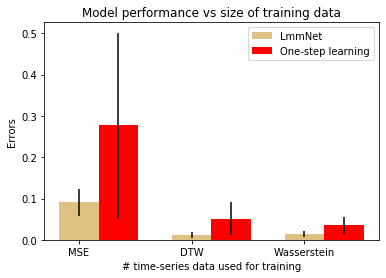

In [14]:
import matplotlib.pyplot as plt
y_pos = np.arange(len(measures))
w = 0.35
#plt.figure(figsize=(12, 8))
#plt.bar(y_pos, means, align='center', yerr = stdevs, color=(0.8, 0.6, 0.2, 0.6))
plt.xticks(y_pos, measures)
plt.ylabel('Errors')
plt.xlabel('# time-series data used for training')
plt.title('Model performance vs size of training data')
plt.bar(y_pos, lmmnet_means, align='center', width=w, yerr = lmmnet_stdevs, color=(0.8, 0.6, 0.2, 0.6), label='LmmNet')
plt.bar(y_pos + w, onestep_means, align='center', width=w, yerr = onestep_stdevs, color='r', label='One-step learning')

plt.legend()
plt.show()

In [15]:
import sys
sys.path.append("./source")

import pandas as pd
import NovakTyson
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import train_onestep
import predict_onestep
from sklearn.ensemble import RandomForestRegressor
from scipy.integrate import odeint
import train_lmmNet
import predict_lmmNet
import tensorflow as tf
import scicomp

In [20]:
N = 50
h = 3.4

# cyclin synthesis and degradation are inhibited
time_points, novak_data = NovakTyson.simulate_custom(step_size=h, tlast=1500)
data_numpy = np.zeros((N, novak_data.shape[1], novak_data.shape[2]))

cyclin_list = np.random.uniform(0, 12, N)
for i in range(N):
    # cyclin synthesis and degradation are inhibited
    _, data_numpy[i, :, :] = NovakTyson.simulate_custom(cyclin = cyclin_list[i], MPF=14, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5, step_size=h)
    
# replace all values that are numerically zero
data_numpy = np.where(data_numpy < 1e-4, 0, data_numpy)
print(data_numpy.shape)

(50, 442, 7)


In [21]:
# select training and test
train_high = tf.convert_to_tensor(data_numpy[1:,:,:], dtype=tf.float32)
test_high = tf.convert_to_tensor(data_numpy[0,:,:], dtype=tf.float32)

model_high = train_lmmNet.train_easy(time_points, train_high)

In [18]:
# use these simulations to generate the bifurcation diagram
N = 25
simulated_high = np.zeros((N, test_high.shape[0], test_high.shape[1]))
init = test_high[0,:].numpy()
cyclin_high = np.random.uniform(0, 9, N)
for i in range(cyclin_high.shape[0]):
    init_copy = init
    init_copy[0] = cyclin_high[i]
    predicted_test = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model_high), init_copy, time_points)
    simulated_high[i,:,:] = predicted_test

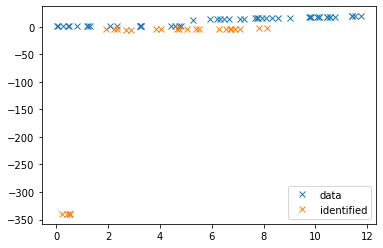

In [19]:
mpf_pred = [simulated_high[i][-1][1] for i in range(N)]
#plt.plot(cyclin_high, np.maximum(mpf_pred, 0), 'x', label='data')
#mpf_norm = NormalizeData(np.maximum(mpf_pred, 0))
mpf_high = [data_numpy[i][-1][1] for i in range(50)]
plt.plot(cyclin_list, mpf_high, 'x', label='data')
plt.plot(cyclin_high, mpf_pred, 'x', label='identified')
plt.legend()
plt.show()